# Studies on Softening and Hardening

In [20]:
%run ../src/game.py
%run ../src/ipd.py
%run ../src/strategies.py
%run ../src/tools.py
g.prettyPrint()   # prisoner's dilemma

        C       D
C  [3, 3]  [0, 5]
D  [5, 0]  [1, 1]


In [ ]:
# example of meeting
m = Meeting(g, Periodic('ccd'), Tft() , length=10)
m.run()
m.prettyPrint()

In [ ]:
# example of a classical tournament
bag = [Periodic('C','allC'), Periodic('D','allD'), Tft(), Periodic('CCD','perCCD') ]
t = Tournament(g,bag,length=10)
t.run()
t.matrix

In [ ]:
e = Ecological(t,pop=100, max_iter=1000)
e.run()
e.drawPlot()

## Classification of strategies

When we look at a set of strategies we see that they have general characteristics that allow them to be classified into large families. The four families we consider are


- IC. a strategy is “initially cooperative” (IC) if it never takes the initiative of defection
- SA. we call “spontaneously aggressive” the complementary set to IC
- IA. a strategy is “initially aggressive” if it never takes the initiative of cooperation
- SC. we call “spontaneously cooperative” the complementary set to IA

Note that each IA strategy is also SA and that each IC strategy is also SC.
On the other hand, it is possible to be IC and SC at the same time.

The `getAgressivityClass` method takes a set of strategies as a parameter and breaks these strategies down into a 4 entry dictionary; one for each of these cl

In [8]:
def getAgressivityClasses(bag):
    aggressivity = {'IC':[], 'SC':[],'IA':[],'SA':[]}
    for strat in bag : 
        m1 = Meeting(g, strat, Periodic('C'), 100)
        m1.run()
        m2 = Meeting(g, strat, Periodic('D'), 100)
        m2.run()
        if m1.s1_score == 300:
             aggressivity['IC'] += [strat]
        if m1.s1_score > 300:
             aggressivity['SA'] += [strat]
        if m2.s1_score == 100:
             aggressivity['IA'] += [strat]
        if m2.s1_score < 100:
             aggressivity['SC'] += [strat]
    return aggressivity
        

ac = getAgressivityClasses(getClassicals()[0:17])
for cle,valeur in ac.items():
    print (cle, len(valeur) , [s.name for s in valeur])

# Take care that the 17th is SpitefulCC, contrary to the Simpat paper in which 
# it's mem2

IC 10 ['allC', 'tft', 'spiteful', 'softmajo', 'pavlov', 'tf2t', 'hardtft', 'slowtft', 'gradual', 'spitefulCC']
SC 14 ['allC', 'tft', 'spiteful', 'softmajo', 'per_DDC', 'per_CCD', 'per_CD', 'pavlov', 'tf2t', 'hardtft', 'slowtft', 'gradual', 'prober', 'spitefulCC']
IA 3 ['allD', 'hardmajo', 'mistrust']
SA 7 ['allD', 'hardmajo', 'per_DDC', 'per_CCD', 'mistrust', 'per_CD', 'prober']


## List of strategies in a family, with their categories

In [15]:
import pandas as pd
bag = getClassicals()[0:17]
ac = getAgressivityClasses(bag)
result=[]
for s in bag :
    lig=[
    'IA' if s in ac['IA'] else '' ,
    'IC' if s in ac['IC'] else '' ,
    'SA' if s in ac['SA'] else '' ,
    'SC' if s in ac['SC'] else ''
    ]
    result.append(lig)
df = pd.DataFrame(result, index=[s.name for s in bag])
df

,0,1,2,3
allC,,IC,,SC
allD,IA,,SA,
tft,,IC,,SC
spiteful,,IC,,SC
softmajo,,IC,,SC
hardmajo,IA,,SA,
per_DDC,,,SA,SC
per_CCD,,,SA,SC
mistrust,IA,,SA,
per_CD,,,SA,SC


## Size of each class for each of the main families

In [12]:
import pandas as pd
result=[]
for bag in [getClassicals()[0:17],getMem(1,1),getMem(1,2),getAllProba(5)] :
    ac = getAgressivityClasses(bag)
    lig=[]
    for cle,valeur in ac.items():
        lig.append(len(valeur))
    result.append(lig)
df = pd.DataFrame(result, columns=list(ac.keys()), index=['classicals','mem11','mem12','mem21'])
df



,IC,SC,IA,SA
classicals,10,14,3,7
mem11,8,24,8,24
mem12,128,896,128,896
mem21,216,2376,216,2376


L'aggressivité des stratégies avant et après simplification

In [21]:
def createTab(bag):
    agr = getAgressivityClasses(bag)
    simplified = simplifyWithTournament(bag, [Periodic('CDCCDDC'), Periodic('DDCDCDD')], 10)
    agrS = getAgressivityClasses(simplified)
    tab = pd.DataFrame(
            np.nan, ["IC","SC","IA", "SA"], ["Before simplify","After simplify"]
        )
    for key in agr :
        tab.at[key,"Before simplify" ] = len(agr[key])
    for key in agrS :
        tab.at[key, "After simplify"] = len(agrS[key])
    pd.options.display.float_format = '{:,.0f}'.format
    return tab

createTab(getMem(1,1))


NameError: name 'simplifyWithTournament' is not defined

# Performance of the strategies in each class ?

    Mean of ranks  Mean of scores
IC              4             400
SC              5             133
IA              5               0
SA              5               0


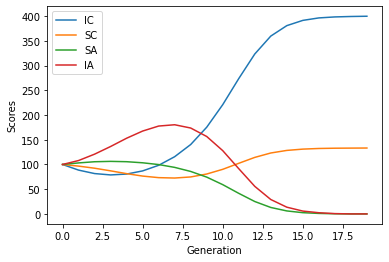

In [19]:
bag = getMem(1,1)
t = Tournament(g,bag,100)
e = Ecological(t, 100)
e.run()
ranking = e.historic.iloc[e.generation].rank(0, method="min", ascending=False)
score = e.historic.iloc[e.generation]
agr = getAgressivityClasses(bag)

# Generate the data with mean of ranks and scores
tab = pd.DataFrame(
            np.nan, ["IC","SC","IA", "SA"], ["Mean of ranks","Mean of scores"]
        )
for key in agr:
    ranks = []
    scores = []
    for strat in agr[key]:
        ranks += [ranking[strat.name]]
        scores += [score[strat.name]]
        
    tab.at[key, "Mean of ranks"] = np.mean(ranks)
    tab.at[key, "Mean of scores"] = np.mean(scores)
pd.options.display.float_format = '{:,.0f}'.format   
print(tab)

# Generate the graph with mean of scores 
ranksIC, ranksSC, ranksIA, ranksSA = [], [], [], []
for i in range(e.generation):
    rIC = 0
    rSC = 0
    rIA = 0
    rSA = 0
    for key in agr:
        for strat in agr[key]:
            if key == "IC":
                rIC += e.historic.iloc[i][strat.name]
            if key == "SC":
                rSC += e.historic.iloc[i][strat.name]
            if key == "IA":
                rIA += e.historic.iloc[i][strat.name]
            if key == "SA":
                rSA += e.historic.iloc[i][strat.name]
    ranksIC += [np.sum(rIC)/len(agr['IC'])]
    ranksSC += [np.sum(rSC)/len(agr['SC'])]
    ranksIA += [np.sum(rIA)/len(agr['IA'])]
    ranksSA += [np.sum(rSA)/len(agr['SA'])]
                
        

plt.plot(ranksIC, label='IC')
plt.plot(ranksSC, label= 'SC')
plt.plot(ranksSA, label='SA')
plt.plot(ranksIA, label='IA')
plt.ylabel('Scores')
plt.xlabel('Generation')
plt.legend()
plt.show()
        